In [5]:
from sklearn.datasets import load_digits
from keras.layers.core import Dense,Activation, Flatten, Dropout
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm
from keras.layers import BatchNormalization, Dropout, Lambda, concatenate
from keras import backend
from keras.layers.advanced_activations import LeakyReLU
from keras.objectives import binary_crossentropy, categorical_crossentropy
from matplotlib import pyplot as plt
from os import makedirs

%matplotlib inline
batch_size = 500
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.001
num_classes = 10
colors = ['blue', 'red', 'green', 'black', 'orange', 'yellow', 'violet', 'gold', 'pink', 'grey']
callback = [EarlyStopping(monitor='val_loss', patience=2)]
makedirs('./model_for_12')

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y = y_train
y_train = to_categorical(y_train).astype(np.float32)
y_test  = to_categorical(y_test).astype(np.float32)
num_classes = y_test.shape[1]

In [17]:
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
x = Dense(512)(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)
x = Dense(256)(x)
x = Dropout(dropout_rate)(x)
x = Activation('relu')(x)
encoded = Dense(latent_dim)(x)

    # На этом моменте представление 2-размерное

input_encoded = Input(shape=(latent_dim,))
x = Dense(256)(input_encoded)
x = Activation('relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(28 * 28)(x)
x = Activation('sigmoid')(x)
decoded = Reshape((28, 28, 1))(x)

    # Модели
encoder = Model(input_img, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

autoencoder.compile(optimizer=Adam(start_lr), loss=binary_crossentropy)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 2)                 533762    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         202256    
Total params: 736,018
Trainable params: 736,018
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = autoencoder.fit(x_train,
                          x_train,
                          batch_size=batch_size,
                          epochs=100,
                          callbacks=callback,
                          verbose=False,
                         validation_data=(x_test, x_test))

print(f'Обучение прекращено на  -  {callback[0].stopped_epoch}  - эпохе')

Обучение прекращено на  -  49  - эпохе


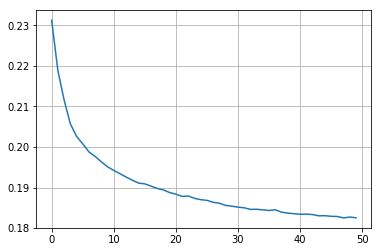

In [19]:
plt.plot(history.history['val_loss'])
plt.grid(True);

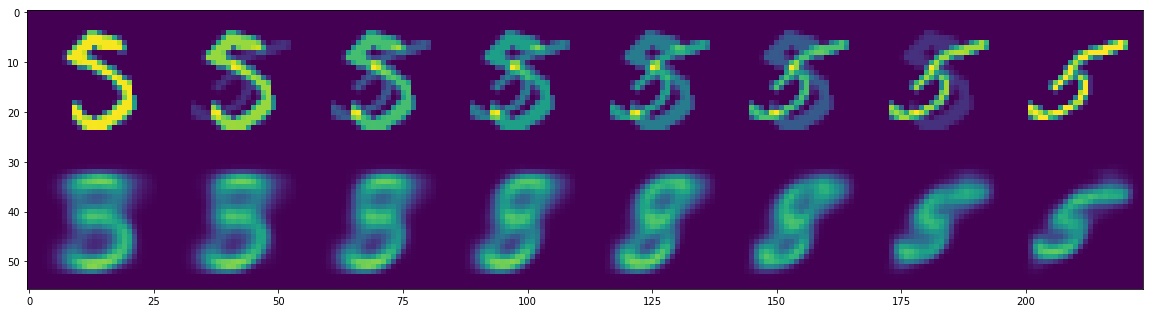

In [20]:
five_start = 11
five_stop = 2

img_1 = x_train[y == 5][five_start].reshape((28, 28))
img_2 = x_train[y == 5][five_stop].reshape((28, 28))

startimg = np.linspace(img_1, img_2, 8)[0]
for im in np.linspace(img_1, img_2, 8)[1:]:
    startimg = np.hstack((startimg, im))
five_origin = startimg

img_1_in_49 = encoder.predict(img_1.reshape((1, 28, 28, 1)))
img_2_in_49 = encoder.predict(img_2.reshape((1, 28, 28, 1)))

startimg = decoder.predict(img_1_in_49).reshape((28,28))
for im in np.linspace(img_1_in_49, img_2_in_49, 8)[1:]:
    pred_img = decoder.predict(im).reshape((28,28))
    startimg = np.hstack((startimg, pred_img))
fig,ax = plt.subplots(1,1,figsize=(20,20))
startimg = np.vstack((five_origin, startimg))
ax.imshow(startimg);

In [8]:
predict = encoder.predict(x_train)

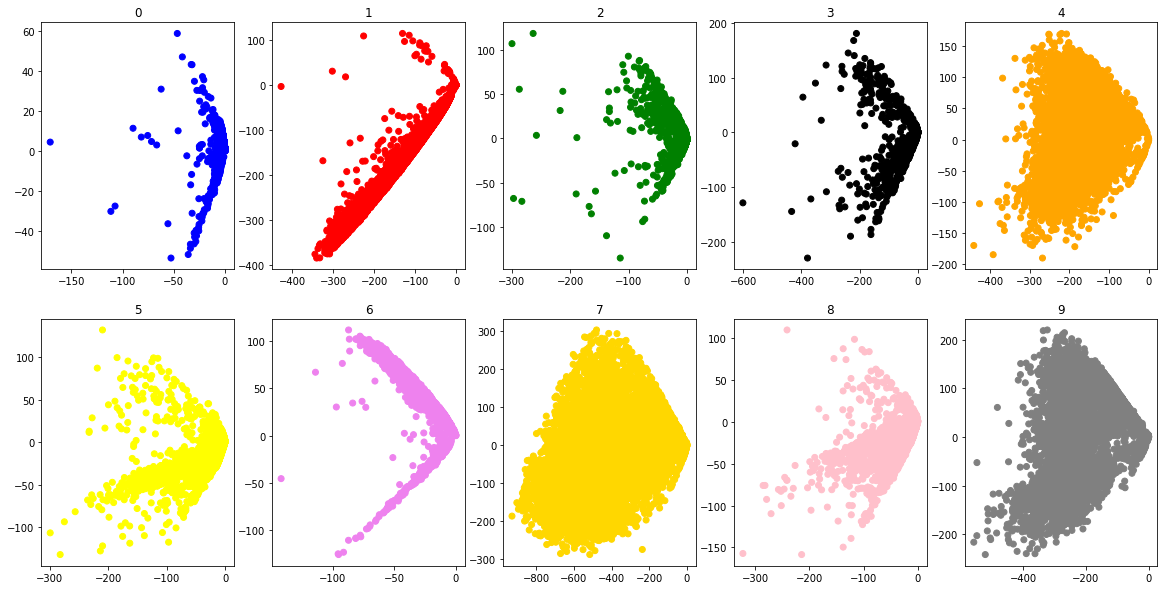

In [9]:
fig, axes = plt.subplots(2,5,figsize=(20,10))

for digit, ax, color in zip(range(10), axes.ravel(), colors):
    ax.scatter(predict[y==digit][:,0], predict[y==digit][:,1], c=[color for i in range(len(predict[y==digit]))])
    ax.set_title(digit)

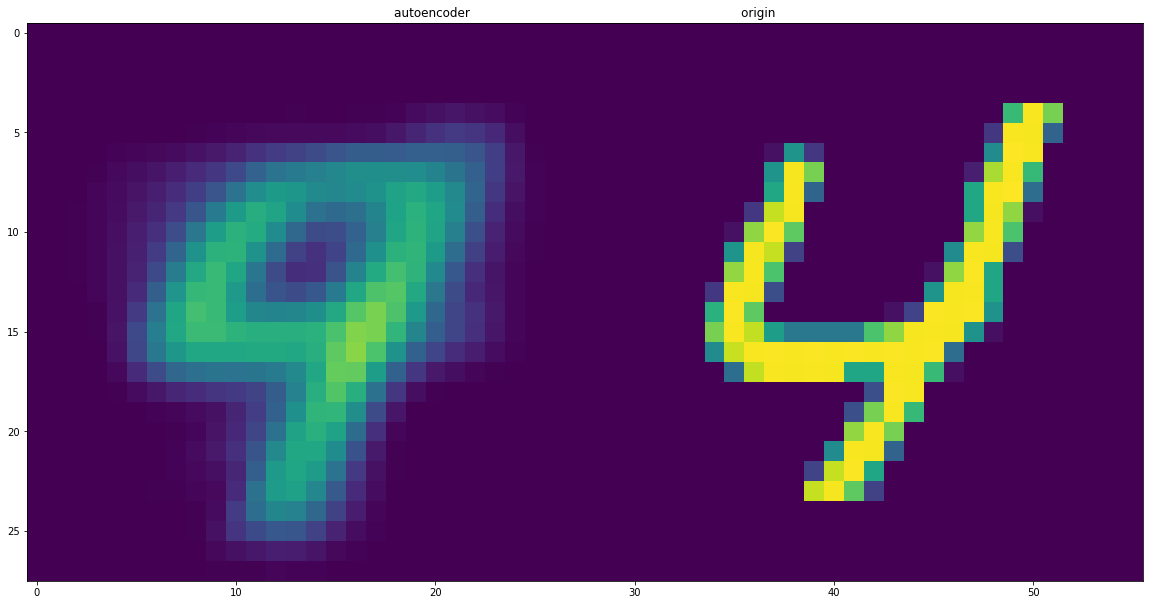

In [10]:
digit_index = 461
aimg = autoencoder.predict(x_train[digit_index].reshape(1,28,28,1)).reshape((28,28))
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(np.hstack((aimg, x_train[digit_index].reshape((28,28)))))
axes.set_title('autoencoder                                                                      origin');

In [11]:
autoencoder.save('./model_for_12/autoencoder.h5')
decoder.save('./model_for_12/decoded.h5')
encoder.save('./model_for_12/encoded.h5')

***

In [12]:
def sampling(args):
        z_mean, z_log_var = args
        epsilon = backend.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + backend.exp(z_log_var / 2) * epsilon

In [13]:
input_img = Input(shape=(28, 28, 1))
flatten_img = Flatten()(input_img)
x = Dense(512)(flatten_img)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
encoded = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])



input_decoder = Input(shape=(latent_dim, ))
x = Dense(256)(input_decoder)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)
x = Dense(512)(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)
x = Dense(28 * 28)(x)
x = Activation('sigmoid')(x)
output_decoder = Reshape((28, 28, 1))(x)

encoder_2 = Model(input_img, encoded, name="encoder")
decoder_2 = Model(input_decoder, output_decoder, name="decoder")
autoencoder_2 = Model(input_img, 
                      decoder_2(encoder_2(input_img)), 
                      name="autoencoder")

In [14]:
autoencoder_2.compile(optimizer=Adam(start_lr), loss=binary_crossentropy)

In [15]:
history = autoencoder_2.fit(x_train,
                          x_train,
                          batch_size=batch_size,
                          epochs=100,
                          callbacks=callback,
                          verbose=False,
                         validation_data=(x_test, x_test))

print(f'Обучение прекращено на  -  {callback[0].stopped_epoch}  - эпохе')

Обучение прекращено на  -  24  - эпохе


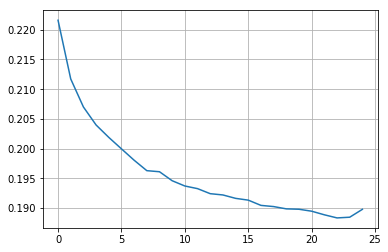

In [16]:
plt.plot(history.history['val_loss'])
plt.grid(True);

In [17]:
predict = encoder_2.predict(x_train, batch_size=batch_size)

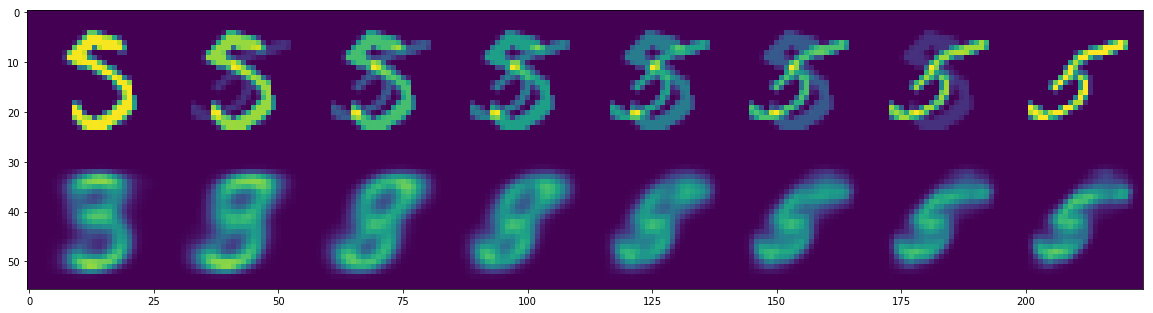

In [18]:
five_start = 11
five_stop = 2
img_1_in_49 = predict[y==5][five_start]
img_2_in_49 = predict[y==5][five_stop]
startimg = decoder_2.predict(img_1_in_49.reshape((1,2))).reshape((28,28))
for im in np.linspace(img_1_in_49, img_2_in_49, 8)[1:]:
    pred_img = decoder_2.predict(im.reshape((1,2))).reshape((28,28))
    startimg = np.hstack((startimg, pred_img))
fig,ax = plt.subplots(1,1,figsize=(20,20))
startimg = np.vstack((five_origin, startimg))
ax.imshow(startimg);

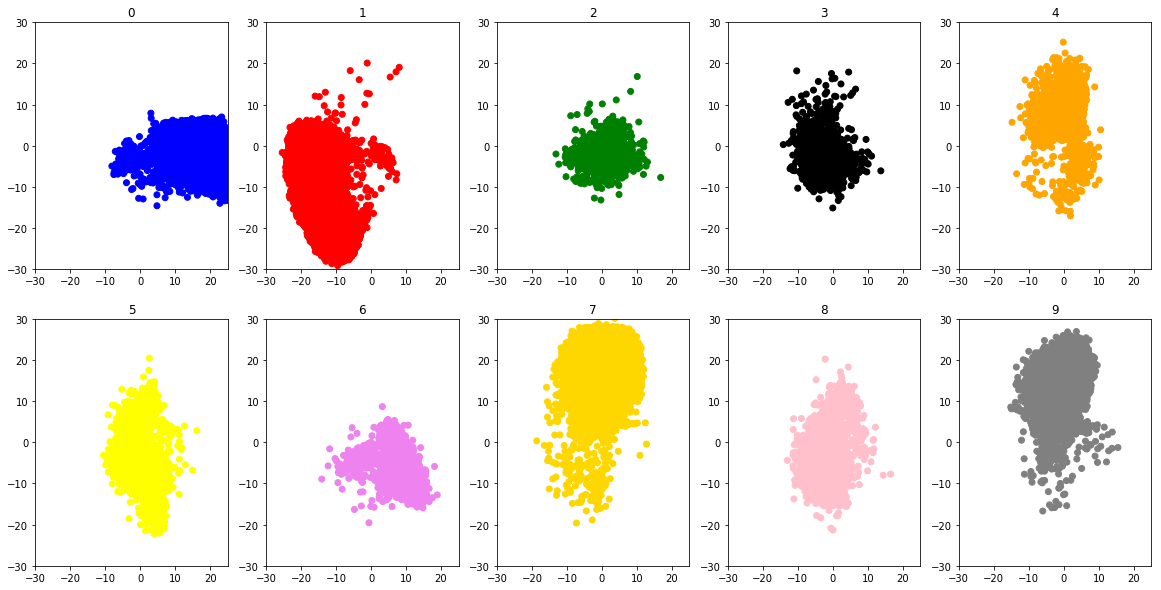

In [19]:
fig, axes = plt.subplots(2,5,figsize=(20,10))

for digit, ax, color in zip(range(10), axes.ravel(), colors):
    ax.scatter(predict[y==digit][:,0], predict[y==digit][:,1], c=[color for i in range(len(predict[y==digit]))])
    ax.set_xlim(-30,25)
    ax.set_ylim(-30,30)
    ax.set_title(digit)

In [20]:
predict = autoencoder_2.predict(x_train, batch_size=batch_size)

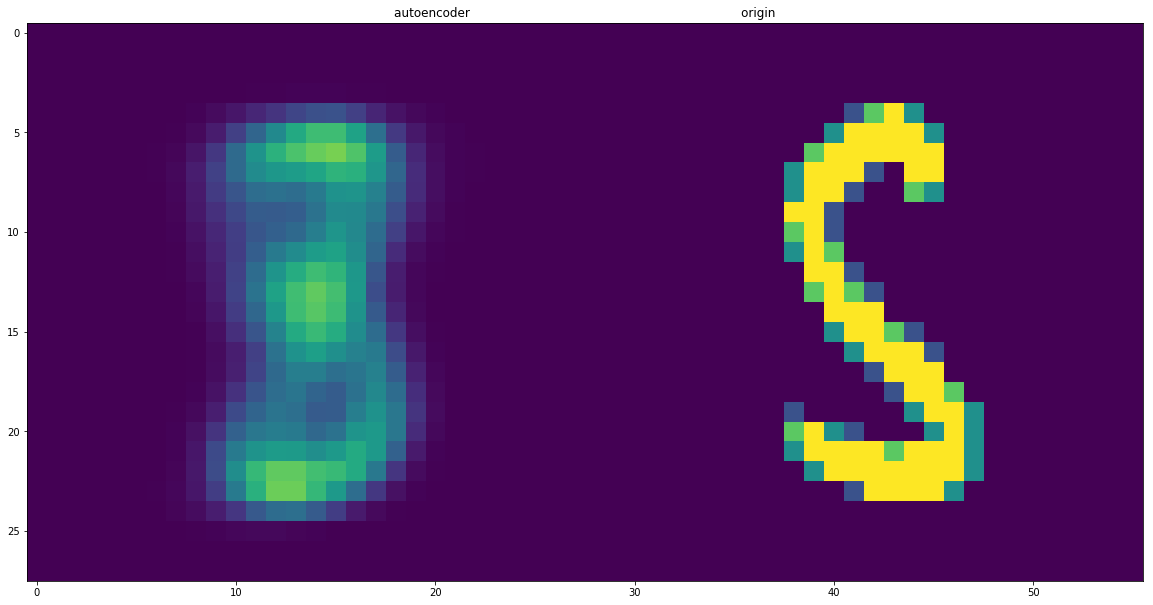

In [21]:
digit_index = 376
aimg = predict[digit_index].reshape((28, 28))
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(np.hstack((aimg, x_train[digit_index].reshape((28,28)))))
axes.set_title('autoencoder                                                                      origin');

In [22]:
autoencoder_2.save('./model_for_12/autoencoder_2_sampling.h5')
decoder_2.save('./model_for_12/decoder_2_sampling.h5')
encoder_2.save('./model_for_12/encoder_2_sampling.h5')

***

In [23]:
input_img = Input(shape=(28, 28, 1))
input_lbl = Input(shape=(num_classes,), dtype='float32')
flatten_img = Flatten()(input_img)
x = concatenate([flatten_img, input_lbl])
x = Dense(512)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
encoded = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])



input_decoder = Input(shape=(latent_dim, ))
input_lbl_d = Input(shape=(num_classes,), dtype='float32')
x = concatenate([input_decoder, input_lbl_d])
x = Dense(256)(x)
x = LeakyReLU()(x)
#x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(512)(x)
x = LeakyReLU()(x)
#x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(28 * 28)(x)
x = Activation('sigmoid')(x)
output_decoder = Reshape((28, 28, 1))(x)

encoder_3 = Model([input_img, input_lbl], encoded, name="encoder")
decoder_3 = Model([input_decoder, input_lbl_d], output_decoder, name="decoder")
autoencoder_3 = Model([input_img, input_lbl, input_lbl_d], 
                      decoder_3([encoder_3([input_img, input_lbl]), input_lbl_d]), 
                      name="autoencoder")

In [24]:
autoencoder_3.compile(optimizer=Adam(start_lr), loss=binary_crossentropy)

In [25]:
history = autoencoder_3.fit([x_train, y_train, y_train],
                            x_train,
                            batch_size=batch_size,
                            validation_data=([x_test, y_test, y_test], x_test),
                             epochs=1000,
                            verbose=False,
                            callbacks=callback)

print(f'Обучение прекращено на  -  {callback[0].stopped_epoch}  - эпохе')

Обучение прекращено на  -  26  - эпохе


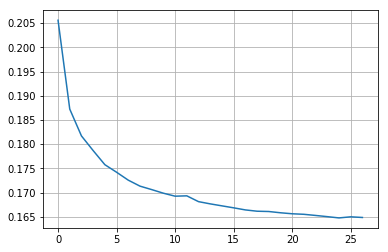

In [26]:
plt.plot(history.history['val_loss'])
plt.grid(True);

In [27]:
predict = autoencoder_3.predict([x_train, y_train, y_train], batch_size=batch_size)

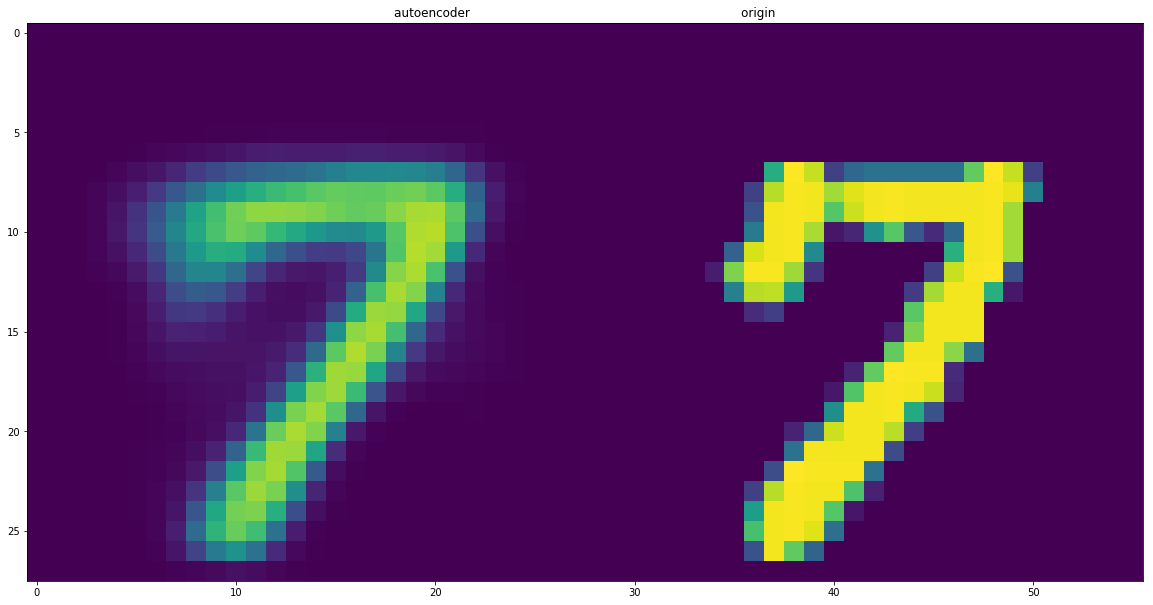

In [28]:
digit_index = 377
aimg = predict[digit_index].reshape((28, 28))
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(np.hstack((aimg, x_train[digit_index].reshape((28,28)))))
axes.set_title('autoencoder                                                                      origin');

In [29]:
predict_e  = encoder_3.predict([x_train, y_train], batch_size=batch_size)

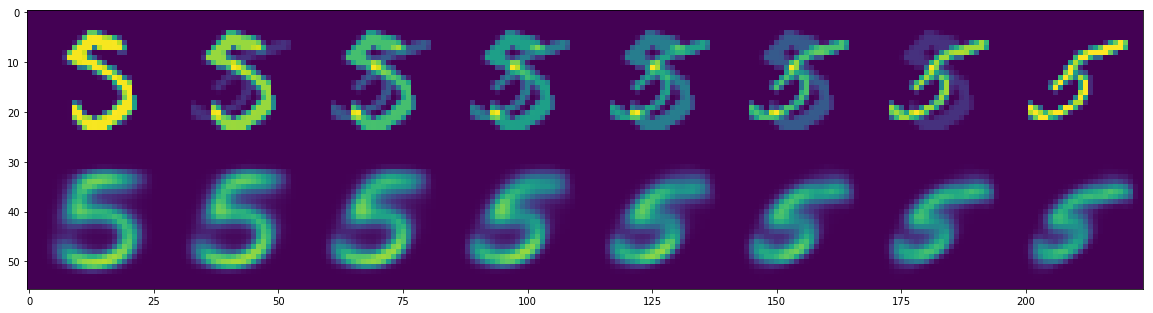

In [30]:
five_start = 11
five_stop = 2
list_of_img = np.linspace(predict_e[y==5][five_start], predict_e[y==5][five_stop], 8)
predict_list_of_img = decoder_3.predict([list_of_img, y_train[y==5][:8]])
start_img = predict_list_of_img[0].reshape((28, 28))
for im in predict_list_of_img[1:]:
    start_img = np.hstack((start_img, im.reshape((28,28))))
fig,axes = plt.subplots(1,1,figsize=(20,20))
start_img = np.vstack((five_origin, start_img))
axes.imshow(start_img);

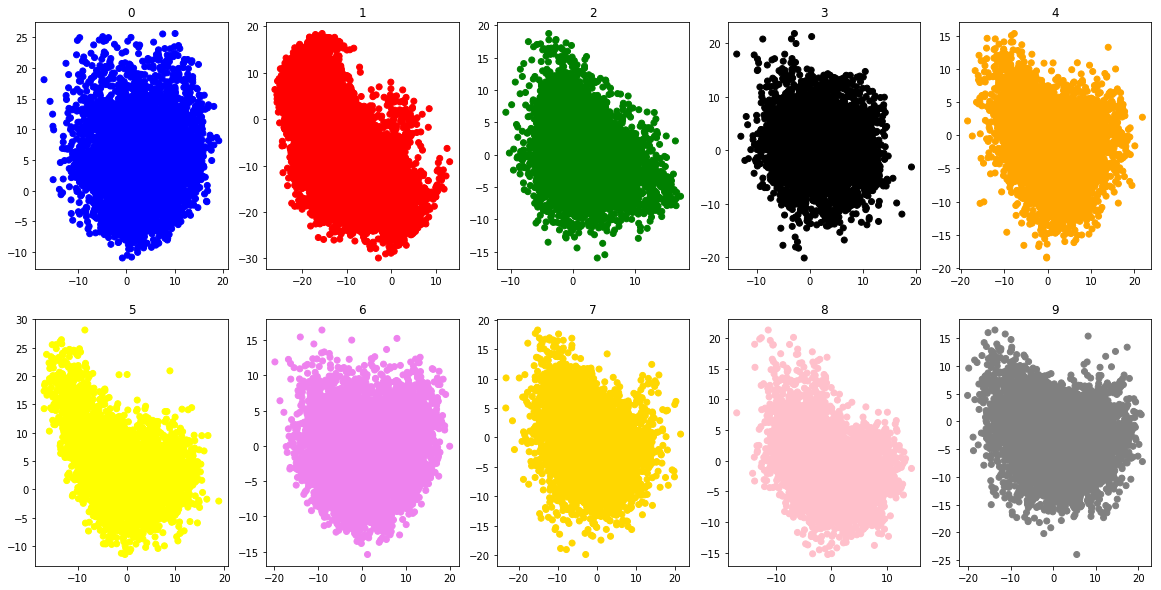

In [31]:
fig, axes = plt.subplots(2,5,figsize=(20,10))
for digit, ax, color in zip(range(10), axes.ravel(), colors):
    ax.scatter(predict_e[y==digit][:,0], predict_e[y==digit][:,1],c=[color for i in range(len(predict_e[y==digit]))])
    #ax.set_xlim(-4.3,4)
    #ax.set_ylim(-4,4)
    ax.set_title(digit)

In [32]:
autoencoder_3.save('./model_for_12/autoencoder_3_sampling_labels.h5')
encoder_3.save('./model_for_12/encoder_3_sampling_labels.h5')
decoder_3.save('./model_for_12/decoder_3_sampling_labels.h5')

***

In [33]:
classfive = to_categorical(5,num_classes=num_classes)
for i in range(499):
    classfive = np.vstack((classfive, to_categorical(5,num_classes=num_classes)))

In [34]:
list_ten_of_five = x_train[y==5][:500]
encode_list_ten_of_five = encoder_3.predict([list_ten_of_five, classfive], batch_size=batch_size)
list_ten_of_five = encode_list_ten_of_five[:10]

In [35]:
allclass = np.vstack(([to_categorical(0, num_classes=10) for i in range(10)]))
for i in range(1, 10):
    allclass = np.vstack((allclass, [to_categorical(i, num_classes=10) for j in range(10)]))

In [36]:
for i in range(9):
    list_ten_of_five = np.vstack((list_ten_of_five, encode_list_ten_of_five[:10]))

In [37]:
list_ten_of_five.shape

(100, 2)

In [38]:
allclass.shape

(100, 10)

In [39]:
decodfive = decoder_3.predict([list_ten_of_five, allclass])

In [40]:
decodfive = decodfive.reshape((100, 28, 28))
decodfive.shape

(100, 28, 28)

In [41]:
field = decodfive[0]
for i,_ in enumerate(decodfive[1:], 1):
    field = np.vstack((field, decodfive[i]))

In [42]:
images = np.hstack(([field[280 * i:280 * (i + 1)]  for i in range(10)]))

In [43]:
origin_five = np.vstack((x_train[y==5][i].reshape((28,28)) for i in range(10)))

c:\users\bogdan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [44]:
images.shape

(280, 280)

In [45]:
origin_five.shape

(280, 28)

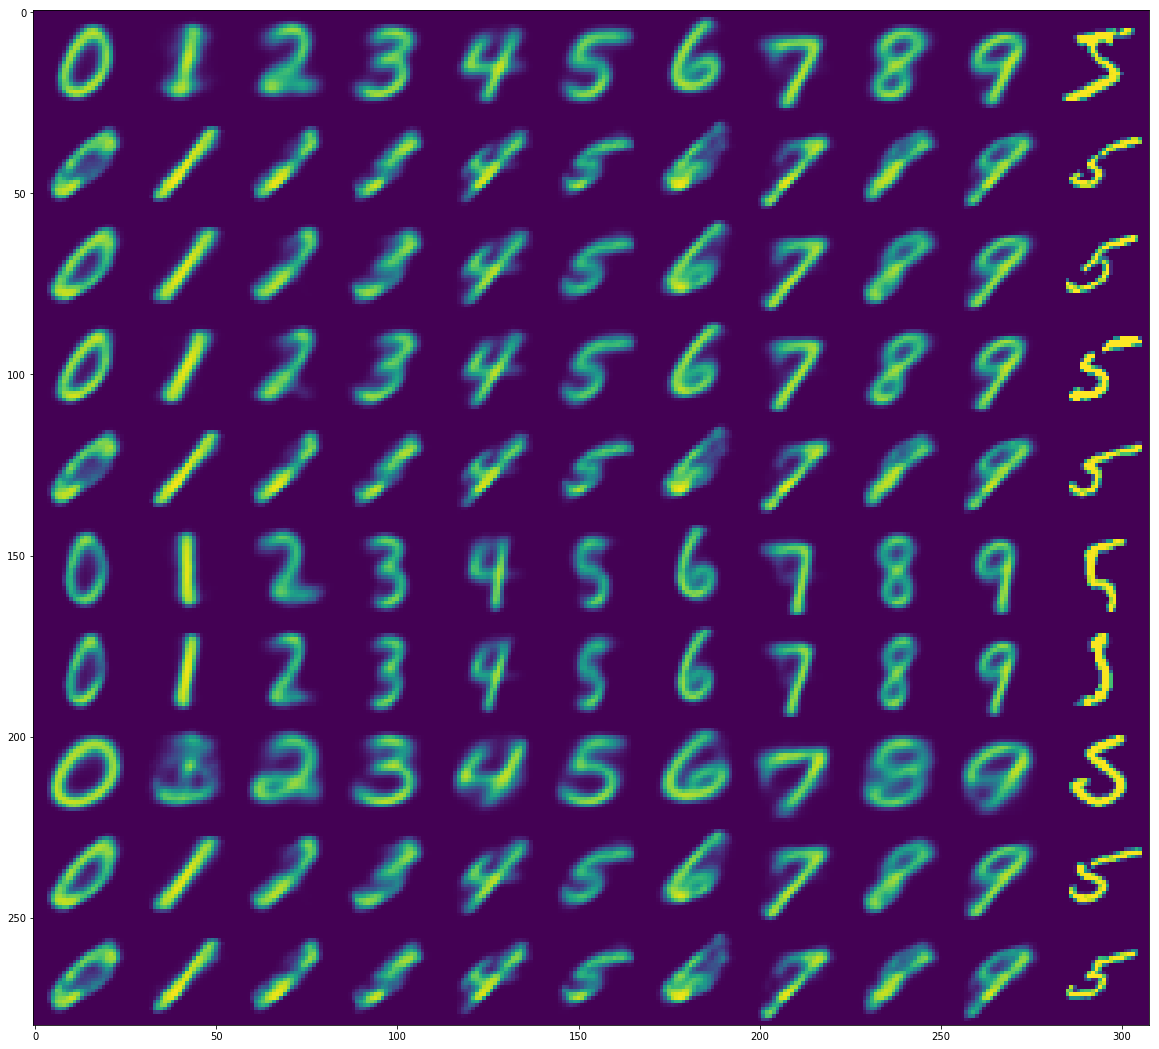

In [46]:
fig,axes = plt.subplots(1,1,figsize=(20,20))
alldigitstyle0 = np.hstack((images, origin_five))
axes.imshow(alldigitstyle0);

In [47]:
plt.imsave('./model_for_12/alldigitstyle_sampling_labels.jpg', alldigitstyle0)

***

[Ствтья про Вариационный энкодер](https://neurohive.io/ru/osnovy-data-science/variacionnyj-avtojenkoder-vae/)

In [48]:
def vae_loss(x, decoded):
        x = backend.reshape(x, shape=(batch_size, 28*28))
        decoded = backend.reshape(decoded, shape=(batch_size, 28*28))
        xent_loss = 28*28*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/28/28

In [49]:
input_img = Input(shape=(28, 28, 1))
input_lbl = Input(shape=(num_classes,), dtype='float32')
flatten_img = Flatten()(input_img)
x = concatenate([flatten_img, input_lbl])
x = Dense(512)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
encoded = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])



input_decoder = Input(shape=(latent_dim, ))
input_lbl_d = Input(shape=(num_classes,), dtype='float32')
x = concatenate([input_decoder, input_lbl_d])
x = Dense(256)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(512)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(28 * 28)(x)
x = Activation('sigmoid')(x)
output_decoder = Reshape((28, 28, 1))(x)

encoder_4 = Model([input_img, input_lbl], encoded, name="encoder")
decoder_4 = Model([input_decoder, input_lbl_d], output_decoder, name="decoder")
autoencoder_4 = Model([input_img, input_lbl, input_lbl_d], 
                      decoder_4([encoder_4([input_img, input_lbl]), input_lbl_d]), 
                      name="autoencoder")

In [50]:
autoencoder_4.compile(optimizer=Adam(start_lr), loss=vae_loss)

In [51]:
history = autoencoder_4.fit([x_train, y_train, y_train],
                            x_train,
                            batch_size=batch_size,
                            validation_data=([x_test, y_test, y_test], x_test),
                             epochs=1000,
                            verbose=False,
                            callbacks=callback)

print(f'Обучение прекращено на  -  {callback[0].stopped_epoch}  - эпохе')

Обучение прекращено на  -  30  - эпохе


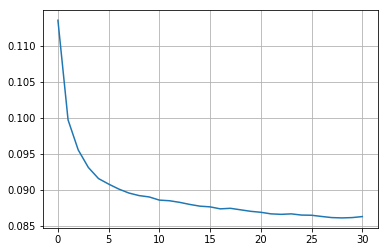

In [52]:
plt.plot(history.history['val_loss'])
plt.grid(True);

In [53]:
predict = autoencoder_4.predict([x_train, y_train, y_train], batch_size=batch_size)

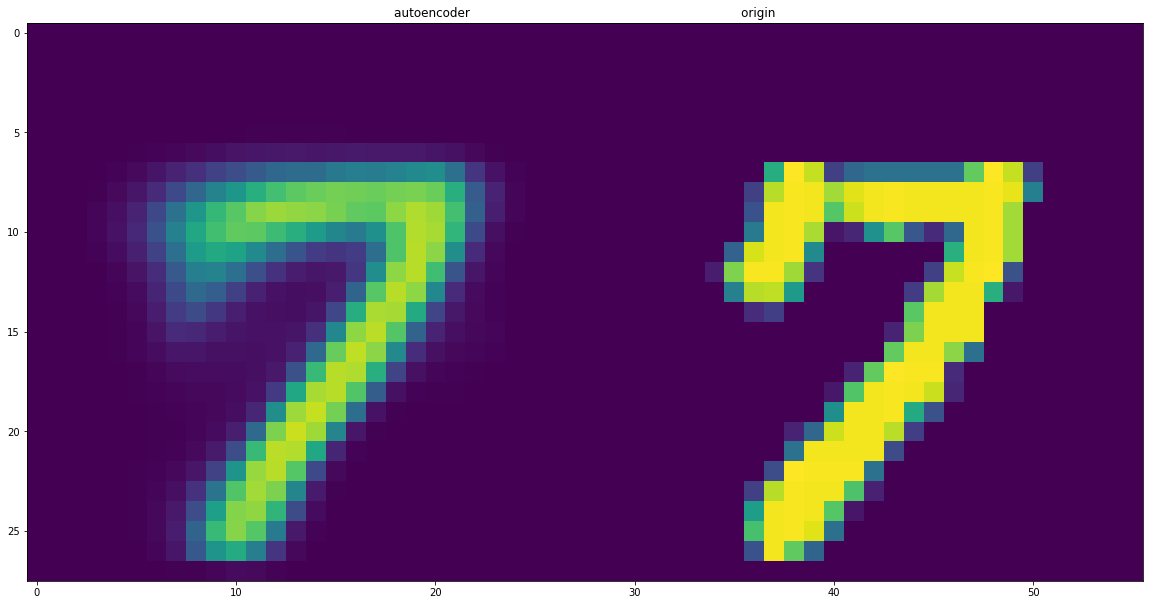

In [54]:
digit_index = 377
aimg = predict[digit_index].reshape((28, 28))
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
axes.imshow(np.hstack((aimg, x_train[digit_index].reshape((28,28)))))
axes.set_title('autoencoder                                                                      origin');

In [55]:
predict_e  = encoder_4.predict([x_train, y_train], batch_size=batch_size)

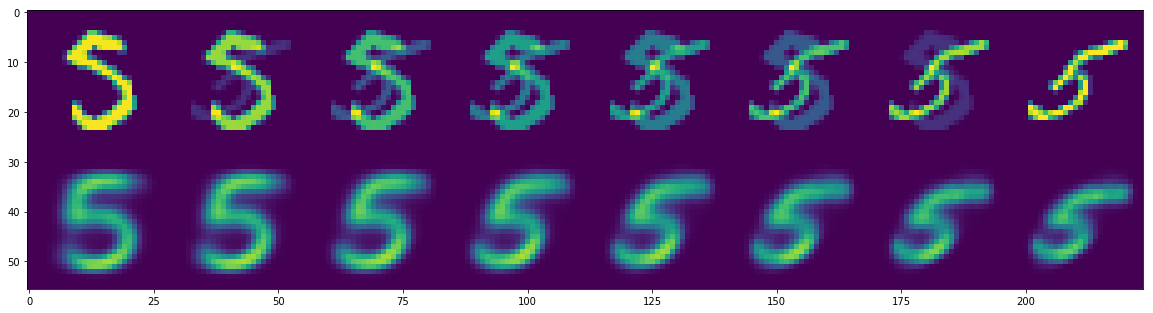

In [56]:
five_start = 11
five_stop = 2
list_of_img = np.linspace(predict_e[y==5][five_start], predict_e[y==5][five_stop], 8)
predict_list_of_img = decoder_4.predict([list_of_img, y_train[y==5][:8]])
start_img = predict_list_of_img[0].reshape((28, 28))
for im in predict_list_of_img[1:]:
    start_img = np.hstack((start_img, im.reshape((28,28))))
fig,axes = plt.subplots(1,1,figsize=(20,20))
start_img = np.vstack((five_origin, start_img))
axes.imshow(start_img);

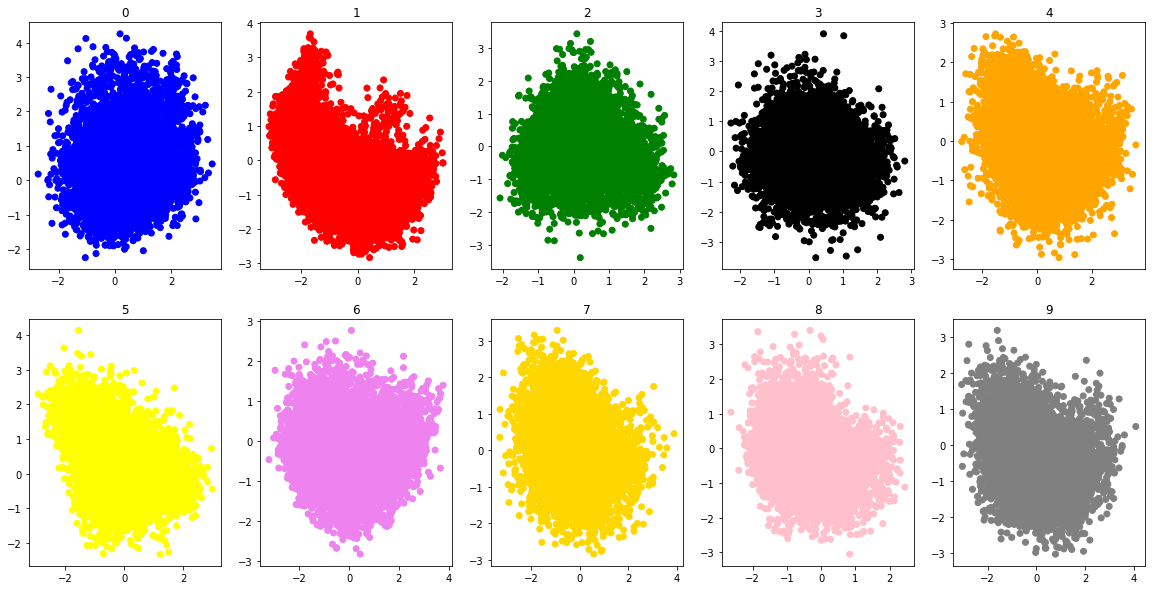

In [57]:
fig, axes = plt.subplots(2,5,figsize=(20,10))
for digit, ax, color in zip(range(10), axes.ravel(), colors):
    ax.scatter(predict_e[y==digit][:,0], predict_e[y==digit][:,1],c=[color for i in range(len(predict_e[y==digit]))])
    #ax.set_xlim(-4.3,4)
    #ax.set_ylim(-4,4)
    ax.set_title(digit)

In [58]:
autoencoder_4.save('./model_for_12/autoencoder_4_sampling_labels_vaeloss.h5')
encoder_4.save('./model_for_12/encoder_4_sampling_labels_vaeloss.h5')
decoder_4.save('./model_for_12/decoder_4_sampling_labels_vaeloss.h5')

In [59]:
classfive = to_categorical(5,num_classes=num_classes)
for i in range(499):
    classfive = np.vstack((classfive, to_categorical(5,num_classes=num_classes)))

list_ten_of_five = x_train[y==5][:500]
encode_list_ten_of_five = encoder_4.predict([list_ten_of_five, classfive], batch_size=batch_size)
list_ten_of_five = encode_list_ten_of_five[:10]

allclass = np.vstack(([to_categorical(0, num_classes=10) for i in range(10)]))
for i in range(1, 10):
    allclass = np.vstack((allclass, [to_categorical(i, num_classes=10) for j in range(10)]))
    
for i in range(9):
    list_ten_of_five = np.vstack((list_ten_of_five, encode_list_ten_of_five[:10]))
    
decodfive = decoder_4.predict([list_ten_of_five, allclass])

decodfive = decodfive.reshape((100, 28, 28))

field = decodfive[0]
for i,_ in enumerate(decodfive[1:], 1):
    field = np.vstack((field, decodfive[i]))

images = np.hstack(([field[280 * i:280 * (i + 1)]  for i in range(10)]))

origin_five = np.vstack((x_train[y==5][i].reshape((28,28)) for i in range(10)))

c:\users\bogdan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


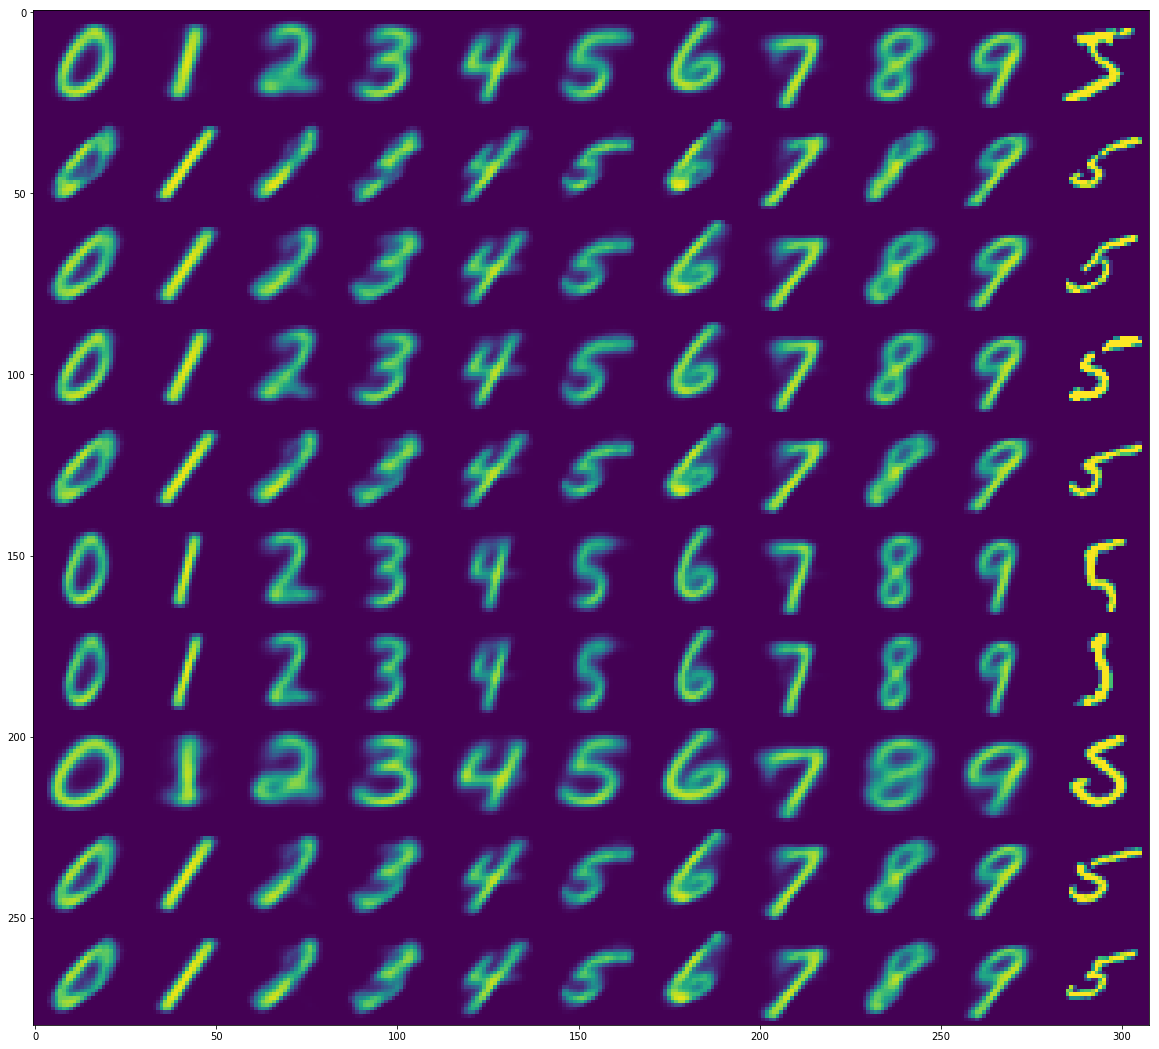

In [60]:
fig,axes = plt.subplots(1,1,figsize=(20,20))
alldigitstyle = np.hstack((images, origin_five))
axes.imshow(alldigitstyle);

In [61]:
plt.imsave('./model_for_12/alldigitstyle_sampling_labels_varloss.jpg', alldigitstyle)